# 聊天机器人 ChatBot
该项目基于PyTorch框架，以Encoder-Decoder架构的Transformer模型实现了Seq2Seq。

- 语料库：小黄鸡（约45万 pairs）
- 使用预训练模型albert作为Encoder并进行微调（hugging face: clue/albert_chinese_tiny）

In [1]:
import torch
from torch import nn
from transformers import BertTokenizer, AlbertModel
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
import pandas as pd
import os
import random
import math
import time

In [2]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

## 理论部分
### Transformer

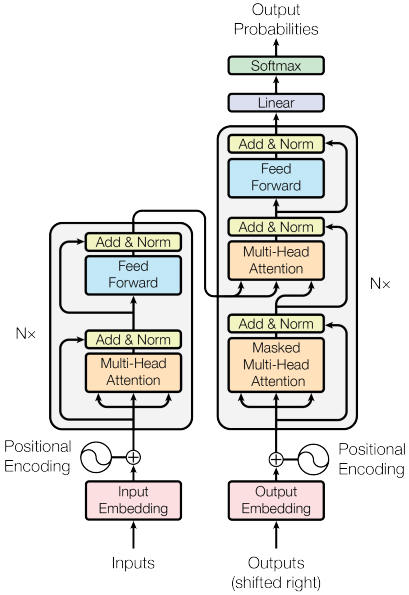
(arXiv:1706.03762)

#### 多头注意力层 (Multi-head Attention Layer)
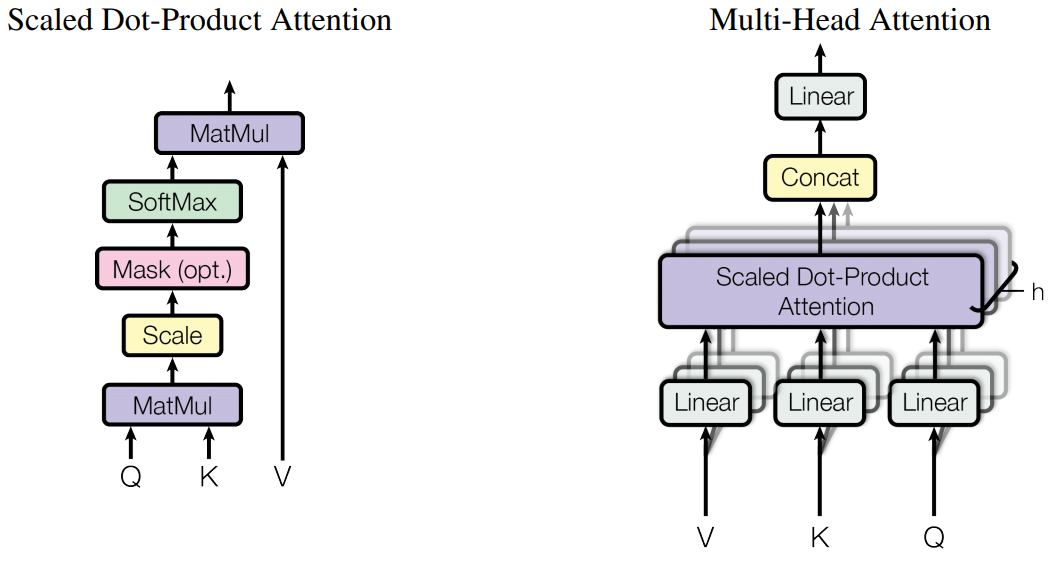(arXiv:1706.03762)

$$\mathrm{Attention}(Q,K,V)=\mathrm{Softmax}(\cfrac{QK^T}{\sqrt{d_k}})V$$
$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$
$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

## 准备工作
### 加载tokenizer
使用预训练模型albert提供的tokenizer，并将bos设定为`[CLS]`，eos设定为`[SEP]`.

In [3]:
tokenizer = BertTokenizer.from_pretrained("clue/albert_chinese_tiny")
# albert = AlbertModel.from_pretrained("clue/albert_chinese_tiny")

#将BERT的[CLS]作为bos，[SEP]作为eos
tokenizer.bos_token = '[CLS]'
tokenizer.bos_token_id = 101
tokenizer.eos_token_ = '[SEP]'
tokenizer.eos_token_id = 102

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.


### 设定超参数

In [4]:
# 设定超参数
dataset_path = '../data/xhj/xiaohuangji50w_nofenci.conv'
dataset_for_test_path = '../data/xhj/test_data.txt'
model_path = '../models/chatbot.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

INPUT_DIM = tokenizer.vocab_size
OUTPUT_DIM = tokenizer.vocab_size
HID_DIM = 312
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
SRC_PAD_IDX = tokenizer.convert_tokens_to_ids('[PAD]')
TRG_PAD_IDX = SRC_PAD_IDX
TRG_EOS_IDX = tokenizer.convert_tokens_to_ids('[SEP]')
LEARNING_RATE = 0.0005
MAX_LEN = 30
BATCH_SIZE = 128
SPLIT_RATIO = 10

### 文本预处理
加载语料库文件并将其处理为`list[tuple[str,str]]`

In [5]:
# 获取问题行
def find_corpus_error(lines):
    error_pos = []
    for index, line in enumerate(lines):
        if not line.startswith(('E', 'M')):
            error_pos.append(index)
    return error_pos

In [ ]:
# 加载语料库
def load_corpus(dataset_path, *, encoding='utf8'):
    with open(dataset_path, 'r', encoding=encoding) as fp:
        lines = fp.readlines()
        # 将所有对话处理到3行内
        error_pos = find_corpus_error(lines)
        error_pos.reverse()
        for i in error_pos:
            # lines[i - 1] = lines[i - 1].rstrip() + '\n'
            lines[i - 1] += lines[i]
        lines_new = []
        for i in range(0, len(lines)):
            if i not in error_pos:
                lines_new.append(lines[i])
        lines = lines_new
        # 去除行首的E和M
        indices_start = list(range(0, len(lines)))[1::3]
        lines = [line[2:].strip() for line in lines]
        corpus = []
        # 构造pair
        for i in indices_start:
            corpus.append((lines[i], lines[i + 1]))
        return corpus

定义`tokenize`函数用于将文本处理为网络需要的输入张量。

In [6]:
def tokenize(text):
    return tokenizer(text=text, add_special_tokens=True, padding='max_length',
                     max_length=MAX_LEN, truncation=True, return_tensors='pt').to(device)

### 定义数据集类
定义数据集类，以供之后调用`DataLoader`时使用。

In [7]:
class CorpusDataset(Dataset):
    def __init__(self, corpus, *, encoding='utf8', transform_feature=None, transform_target=None):
        self.corpus = corpus
        self.transform_feature = transform_feature
        self.transform_target = transform_target

    def __len__(self):
        return len(self.corpus)

    def __getitem__(self, idx):
        question = self.corpus[idx][0]
        answer = self.corpus[idx][1]
        if self.transform_feature is not None:
            question = self.transform_feature(question)
        if self.transform_target is not None:
            answer = self.transform_target(answer)
        return question, answer

定义`split_corpus`函数，用于分割训练集与验证集。

In [ ]:
def split_corpus(corpus, ratio):
    valid_indices = random.sample(range(len(corpus)), len(corpus) // ratio)
    train_corpus = []
    valid_corpus = []
    for idx in range(len(corpus)):
        if idx in valid_indices:
            valid_corpus.append(corpus[idx])
        else:
            train_corpus.append(corpus[idx])
    return train_corpus, valid_corpus

### 定义多头注意力层

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super(MultiHeadAttention, self).__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)


    def forward(self, query, key, value, mask=None):
        # Q:    [batch_size, query_len, hid_dim]
        # K:    [batch_size, key_len, hid_dim]
        # V:    [batch_size, value_len, hid_dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        # Q:    [batch_size, n_heads, query_len, head_dim]
        # K:    [batch_size, n_heads, key_len, head_dim]
        # V:    [batch_size, n_heads, value_len, head_dim]
        Q = Q.view(batch_size, -1 ,self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1 ,self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1 ,self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # attention:    [batch_size, n_heads, query_len, key_len]
        attention = (Q @ K.permute(0, 1, 3, 2))/ self.scale

        if mask is not None:
            attention = attention.masked_fill(mask==0, -1e10)

        # attention:    [batch_size, n_heads, query_len, head_dim]
        attention = self.dropout(torch.softmax(attention, dim=-1)) @ V

        # attention:    [batch_size, query_len, hid_dim]
        attention = attention.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.hid_dim)

        return self.fc_o(attention)

### 定义 Position-wise Feed-forward 层

In [9]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super(PositionWiseFeedForward, self).__init__()
        self.hid_dim = hid_dim
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc_1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc_2(x)
        return x

### 定义 Decoder Layer

In [10]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super(DecoderLayer, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.self_attention = MultiHeadAttention(hid_dim, n_heads, dropout, device)
        self.enc_attention = MultiHeadAttention(hid_dim, n_heads, dropout, device)
        self.pff = PositionWiseFeedForward(hid_dim, pf_dim, dropout)
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.pff_layer_norm = nn.LayerNorm(hid_dim)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        trg_ = trg
        trg = self.dropout(self.self_attention(trg, trg, trg, trg_mask)) + trg_
        trg = self.self_attn_layer_norm(trg)

        trg_ = trg
        trg = self.enc_attention(trg, enc_src, enc_src, src_mask)
        trg = self.dropout(trg) + trg_
        trg = self.enc_attn_layer_norm(trg)

        trg_ = trg
        trg = self.pff(trg)
        trg = self.dropout(trg) + trg_
        trg = self.pff_layer_norm(trg)

        return trg

### 定义 Decoder 类

In [11]:
class Decoder(nn.Module):
    def __init__(self, output_size, n_layers, hid_dim, n_heads, pf_dim, dropout, device, max_length=MAX_LEN):
        super(Decoder, self).__init__()
        self.tok_emb = nn.Embedding(output_size, hid_dim)
        self.pos_emb = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.fc_o = nn.Linear(hid_dim, output_size)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        self.device = device
        #

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg:      [batch_size, trg_len]
        # enc_src:  [batch_size, src_len, hid_dim]
        # trg_mask: [batch_size, 1, trg_len, trg_len]
        # src_mask: [batch_size, 1, 1, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # pos:      [batch_size, trg_len]
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # trg:      [batch_size, trg_len, hid_dim]
        trg = self.dropout(self.tok_emb(trg) * self.scale + self.pos_emb(pos))

        for layer in self.layers:
            trg = layer(trg, enc_src, trg_mask, src_mask)

        # return: [batch_size, trg_len, output_size] ,token multi-class
        return self.fc_o(trg)

### 定义 Seq2Seq 类

In [12]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

        self.trained_epochs = 0
        self.best_loss = float('inf')
        self.train_ppl = []
        self.valid_ppl = []

    def make_src_mask(self, src:torch.Tensor):
        # src_mask = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len]
        return (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

    def make_trg_mask(self, trg:torch.Tensor):
        #trg = [batch size, trg len]
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)

        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()

        #trg_sub_mask = [trg len, trg len]
        trg_mask = trg_pad_mask & trg_sub_mask

        #trg_mask = [batch size, 1, trg len, trg len]
        return trg_mask

    def forward(self, src, trg):
        # src: [batch_size, src_len]
        # trg: [batch_size, src_trg]
        src_mask = self.make_src_mask(src.input_ids)
        trg_mask = self.make_trg_mask(trg)

        # 使用albert, src保留tokenizer的结构化输出作为输入，而trg只需要给输入input_ids
        # src: [batch_size, src_len, hid_dim]
        # 从albert的输出获取last_hidden_state
        src = self.encoder(src.input_ids, src.attention_mask, src.token_type_ids).last_hidden_state
        trg = self.decoder(trg, src, trg_mask, src_mask)

        # trg:  [batch_size, trg_len, vocab_size]
        return trg

### 实例化模型
载入预训练模型albert作为编码器，构造一个新的解码器，从而实例化一个Seq2Seq模型。

同时，定义损失函数为交叉熵函数，忽略PAD；定义优化器为Adam。

In [13]:
encoder = AlbertModel.from_pretrained("clue/albert_chinese_tiny")
decoder = Decoder(OUTPUT_DIM, DEC_LAYERS, HID_DIM, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

if os.path.exists(model_path):
    model = torch.load(model_path)
else:
    model = Seq2Seq(encoder, decoder, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

Some weights of the model checkpoint at clue/albert_chinese_tiny were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


统计模型参数：

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,605,176 trainable parameters


对模型参数进行初始化。

In [15]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.decoder.apply(initialize_weights); # 仅初始化decoder的参数

### 定义预测函数
函数`generate_answer`将问题输入模型，生成一个答复。

In [138]:
def generate_answer(question, tokenizer:BertTokenizer, model:Seq2Seq, device, max_len = MAX_LEN):
    model.eval()
    question = tokenize(question)
    input_ids = question.input_ids
    src_mask = question.attention_mask
    token_type_ids = question.token_type_ids
    batch_size = input_ids.shape[0]

    with torch.no_grad():
        enc_src = model.encoder(input_ids, src_mask, token_type_ids).last_hidden_state

    src_mask = model.make_src_mask(question.input_ids)
    trg_indices = [[tokenizer.bos_token_id] for _ in range(batch_size)]
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indices).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)

        with torch.no_grad():
            output = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)

        # maybe beam search
        pred_token = [i.item() for i in output.argmax(2)[:,-1]] # greedy

        for j in range(batch_size):
            trg_indices[j].append(pred_token[j])

        if pred_token == [tokenizer.eos_token_id for _ in range(batch_size)]:
            break
    output_indices = [indices[1:-1] for indices in trg_indices]
    washed_indices = []
    for indices in output_indices:
        this_indices = []
        for idx in indices:
            if idx == tokenizer.eos_token_id:
                break
            else:
                this_indices.append(idx)
        washed_indices.append(this_indices)
    answer = [tokenizer.decode(indices).strip() for indices in washed_indices]
    return answer


## 模型训练
### 定义训练函数

In [17]:
def train(model, iter, optimiser, loss_fn, clip):
    model.train()
    epoch_loss = 0
    counter = 0
    for questions, answers in iter:
        counter += 1
        # 张量化
        # t1 = time.time()
        questions = tokenize(questions) # [batch_size, src_len]
        answers = tokenize(answers).input_ids   # [batch_size, trg_len]

        # t2 = time.time()
        optimiser.zero_grad()
        # output:   [batch_size, trg_len, vocab_size]
        output = model(questions, answers.masked_fill(answers==TRG_EOS_IDX, value=TRG_PAD_IDX)[:,:-1]) # 将去除eos的部分作为输入，去掉尾端

        vocab_size = output.shape[2]
        output = output.contiguous().view(-1, vocab_size) # [batch_size * trg_len, vocab_size]

        trg = answers[:,1:].contiguous().view(-1)  #   [batch_size * trg_len]

        loss = loss_fn(output, trg) #
        # t3 = time.time()

        loss.backward()
        # t4 = time.time()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # t5 = time.time()
        optimiser.step()

        epoch_loss += loss.item()
        if counter % 500 == 0:
            print(f'train: epoch {model.trained_epochs+1}, iter {counter}')
        # print(f't3:{t4-t3},t4:{t5-t4}')

    model.trained_epochs += 1
    return epoch_loss / len(iter)

### 定义评估函数

In [18]:
def evaluate(model, iter, loss_fn):
    model.eval()
    epoch_loss = 0
    counter = 0
    for questions, answers in iter:
        counter += 1
        questions = tokenize(questions)
        answers = tokenize(answers).input_ids

        with torch.no_grad():
            output = model(questions, answers.masked_fill(answers==TRG_EOS_IDX, value=TRG_PAD_IDX)[:,:-1])

        vocab_size = output.shape[2]
        output = output.contiguous().view(-1, vocab_size)

        trg = answers[:,1:].contiguous().view(-1)
        epoch_loss += loss_fn(output, trg).item()
        if counter % 500 == 0:
            print(f'valid: epoch {model.trained_epochs}, iter {counter}')

    return epoch_loss / len(iter)

### 定义计时函数

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

### 实例化数据集
通过`load_corpus`函数得到数据集，并通过`DataLoader`载入。

In [20]:
%%time
train_dataset, valid_corpus = split_corpus(load_corpus(dataset_path), SPLIT_RATIO)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_corpus, batch_size=BATCH_SIZE, shuffle=True)

CPU times: total: 2min 34s
Wall time: 2min 34s


In [21]:
from torchtext.data.metrics import bleu_score
candidate_corpus = [['我', '是', '一', '只', '鸡'], ['欧', '内', '的', '手', '好', '汉']]
references_corpus = [[['我', '是', '一', '只', '寄']], [['欧', '内', '的', '手', '好', '汉']]]
bleu_score(candidate_corpus, references_corpus)

0.862778902053833

### 训练

In [38]:
# 训练
N_EPOCHS = 8
CLIP = 1

best_valid_loss = float('inf')

annotation = 'lr=0.0005'
model_path = f'../models/chatbot_{annotation}.pth'

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_dataloader, optimiser, loss_fn, CLIP)
    valid_loss = evaluate(model, valid_dataloader, loss_fn)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    model.train_ppl.append(math.exp(train_loss))
    model.valid_ppl.append(math.exp(valid_loss))

    if valid_loss < model.best_loss:
        model.best_loss = valid_loss
        torch.save(model, model_path)

    print(f'Epoch: {model.trained_epochs:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

train: epoch 3, iter 500
train: epoch 3, iter 1000
train: epoch 3, iter 1500
train: epoch 3, iter 2000
train: epoch 3, iter 2500
train: epoch 3, iter 3000
Epoch: 03 | Time: 8m 49s
	Train Loss: 2.513 | Train PPL:  12.348
	 Val. Loss: 2.371 |  Val. PPL:  10.708
train: epoch 4, iter 500
train: epoch 4, iter 1000
train: epoch 4, iter 1500
train: epoch 4, iter 2000
train: epoch 4, iter 2500
train: epoch 4, iter 3000
Epoch: 04 | Time: 8m 58s
	Train Loss: 2.367 | Train PPL:  10.666
	 Val. Loss: 2.267 |  Val. PPL:   9.654
train: epoch 5, iter 500
train: epoch 5, iter 1000
train: epoch 5, iter 1500
train: epoch 5, iter 2000
train: epoch 5, iter 2500
train: epoch 5, iter 3000
Epoch: 05 | Time: 8m 42s
	Train Loss: 2.269 | Train PPL:   9.666
	 Val. Loss: 2.198 |  Val. PPL:   9.009
train: epoch 6, iter 500
train: epoch 6, iter 1000
train: epoch 6, iter 1500
train: epoch 6, iter 2000
train: epoch 6, iter 2500
train: epoch 6, iter 3000
Epoch: 06 | Time: 8m 38s
	Train Loss: 2.195 | Train PPL:   8.980


In [143]:
lr_valid_ppl

,lr=0.0005,lr=0.0004,lr=0.0003,lr=0.0006
0,17.516548,18.378200,20.182099,17.223696
1,12.620281,12.963000,13.883947,12.827267
2,10.708225,10.777579,11.447501,11.079706
3,9.653572,9.685975,10.046456,10.169067
4,9.009039,8.952663,9.267347,9.575223
5,8.623116,8.475491,8.694265,9.143869
6,8.250907,8.179128,8.290254,8.848366
7,7.979891,7.824058,7.966858,8.624053
8,7.926383,7.692901,7.713332,8.463396
9,7.672000,7.467608,7.603678,8.296318


In [142]:
# 重置参数，训练
N_EPOCHS = 10
CLIP = 1

encoder_ = AlbertModel.from_pretrained("clue/albert_chinese_tiny")
decoder_ = Decoder(OUTPUT_DIM, 3, HID_DIM, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)
model_ = Seq2Seq(encoder_, decoder_, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimiser_ = torch.optim.Adam(model_.parameters(), lr=0.0006)
loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
model_.decoder.apply(initialize_weights); # 仅初始化decoder的参数

best_valid_loss = float('inf')
annotation = 'lr=0.0006'
model_path = f'../models/chatbot_{annotation}.pth'

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model_, train_dataloader, optimiser_, loss_fn, CLIP)
    valid_loss = evaluate(model_, valid_dataloader, loss_fn)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    model_.train_ppl.append(math.exp(train_loss))
    model_.valid_ppl.append(math.exp(valid_loss))

    if valid_loss < model_.best_loss:
        model_.best_loss = valid_loss
        torch.save(model_, model_path)

    print(f'Epoch: {model_.trained_epochs:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

lr_valid_ppl[annotation]=model_.valid_ppl

Some weights of the model checkpoint at clue/albert_chinese_tiny were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train: epoch 1, iter 500
train: epoch 1, iter 1000
train: epoch 1, iter 1500
train: epoch 1, iter 2000
train: epoch 1, iter 2500
train: epoch 1, iter 3000
Epoch: 01 | Time: 9m 0s
	Train Loss: 3.487 | Train PPL:  32.677
	Val. Loss: 2.846 |  Val. PPL:  17.224
train: epoch 2, iter 500
train: epoch 2, iter 1000
train: epoch 2, iter 1500
train: epoch 2, iter 2000
train: epoch 2, iter 2500
train: epoch 2, iter 3000
Epoch: 02 | Time: 8m 22s
	Train Loss: 2.766 | Train PPL:  15.887
	Val. Loss: 2.552 |  Val. PPL:  12.827
train: epoch 3, iter 500
train: epoch 3, iter 1000
train: epoch 3, iter 1500
train: epoch 3, iter 2000
train: epoch 3, iter 2500
train: epoch 3, iter 3000
Epoch: 03 | Time: 8m 14s
	Train Loss: 2.538 | Train PPL:  12.653
	Val. Loss: 2.405 |  Val. PPL:  11.080
train: epoch 4, iter 500
train: epoch 4, iter 1000
train: epoch 4, iter 1500
train: epoch 4, iter 2000
train: epoch 4, iter 2500
train: epoch 4, iter 3000
Epoch: 04 | Time: 8m 11s
	Train Loss: 2.409 | Train PPL:  11.128
	Val

In [140]:
#调参，从头训练
mh_valid_ppl = pd.DataFrame()

for heads in [6,7,8,9,10]:
    N_EPOCHS = 10
    CLIP = 1

    encoder_ = AlbertModel.from_pretrained("clue/albert_chinese_tiny")
    decoder_ = Decoder(OUTPUT_DIM, DEC_LAYERS, HID_DIM, heads, DEC_PF_DIM, DEC_DROPOUT, device)
    model_ = Seq2Seq(encoder_, decoder_, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

    optimiser_ = torch.optim.Adam(model_.parameters(), lr=0.0006)
    loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
    model_.decoder.apply(initialize_weights); # 仅初始化decoder的参数

    annotation = f'lr=0.0006'
    model_path = f'../models/chatbot_{annotation}.pth'

    for epoch in range(N_EPOCHS):

        start_time = time.time()

        train_loss = train(model_, train_dataloader, optimiser_, loss_fn, CLIP)
        valid_loss = evaluate(model_, valid_dataloader, loss_fn)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        model_.train_ppl.append(math.exp(train_loss))
        model_.valid_ppl.append(math.exp(valid_loss))

        if valid_loss < model_.best_loss:
            model_.best_loss = valid_loss
            torch.save(model_, model_path)

        print(f'Epoch: {model_.trained_epochs:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    mh_valid_ppl[f'heads={heads}'] = model_.valid_ppl

Some weights of the model checkpoint at clue/albert_chinese_tiny were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


train: epoch 1, iter 500
train: epoch 1, iter 1000
train: epoch 1, iter 1500
train: epoch 1, iter 2000
train: epoch 1, iter 2500
train: epoch 1, iter 3000
Epoch: 01 | Time: 10m 0s
	Train Loss: 4.117 | Train PPL:  61.366
	Val. Loss: 3.251 |  Val. PPL:  25.818
train: epoch 2, iter 500
train: epoch 2, iter 1000
train: epoch 2, iter 1500
train: epoch 2, iter 2000
train: epoch 2, iter 2500
train: epoch 2, iter 3000
Epoch: 02 | Time: 10m 31s
	Train Loss: 3.119 | Train PPL:  22.634
	Val. Loss: 2.829 |  Val. PPL:  16.922
train: epoch 3, iter 500
train: epoch 3, iter 1000
train: epoch 3, iter 1500
train: epoch 3, iter 2000
train: epoch 3, iter 2500
train: epoch 3, iter 3000
Epoch: 03 | Time: 10m 4s
	Train Loss: 2.801 | Train PPL:  16.466
	Val. Loss: 2.595 |  Val. PPL:  13.398
train: epoch 4, iter 500
train: epoch 4, iter 1000
train: epoch 4, iter 1500
train: epoch 4, iter 2000
train: epoch 4, iter 2500
train: epoch 4, iter 3000
Epoch: 04 | Time: 10m 15s
	Train Loss: 2.601 | Train PPL:  13.481
	

Some weights of the model checkpoint at clue/albert_chinese_tiny were not used when initializing AlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight', 'predictions.LayerNorm.weight', 'predictions.decoder.weight', 'predictions.LayerNorm.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: shape '[128, -1, 7, 44]' is invalid for input of size 1158144

## 调参
只对两个超参数进行了调整，它们的初始值设定:
- learning_rate=0.0005
- dec_layers=3（解码器中DecoderLayer的层数）

首先按初始参数设定训练了10个epochs，PPL图如下：

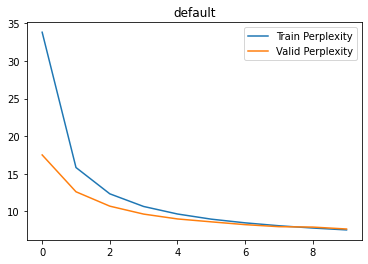

In [40]:
plt.title('default')
plt.plot(model.train_ppl, label='Train Perplexity')
plt.plot(model.valid_ppl, label='Valid Perplexity')
plt.legend()
plt.show()

根据观察，模型正常收敛，但还有一定训练的空间。

考虑到训练速度，固定batch_size为128这个比较大的值不作调整，然后调整学习率以取得最佳效果。

于是，将`[0.0003:0.0006:0.0001]`作为待训练参数列表进行训练，并将所得模型的验证误差作图如下：

In [ ]:
dl_valid_ppl = pd.read_csv('../models/dl_valid_ppl.csv')

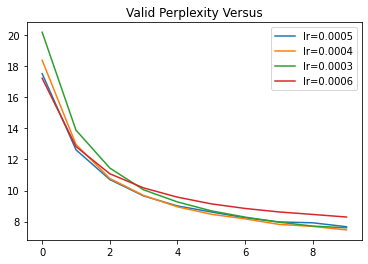

In [145]:
plt.title('Valid Perplexity Versus')
plt.plot(lr_valid_ppl, label=lr_valid_ppl.columns)
plt.legend()
plt.show()

可见在大概5个epoch后，0.0006的学习率明显劣于其他几个参数。

为了便于观察，取后5个epoch的数据进行绘制：

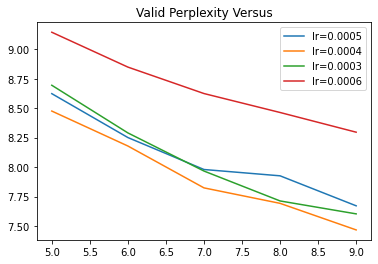

In [146]:
plt.title('Valid Perplexity Versus')
plt.plot(lr_valid_ppl[5:], label=lr_valid_ppl.columns)
plt.legend()
plt.show()

经观察，lr=0.0004能达到最好的效果，于是接下来固定学习率为0.0004，进行Decoder Layer的层数调整。

对于这个参数，我从`range(1,7)`中进行测试，结果如下：

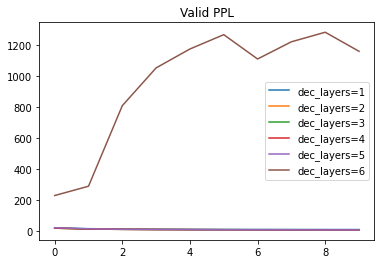

In [98]:
plt.title('Valid PPL')
plt.plot(dl_valid_ppl, label=dl_valid_ppl.columns)
plt.legend()
plt.show()

看来该参数从6开始会导致模型无法收敛。

接下来去除掉`dec_layers=6`的数据绘图：

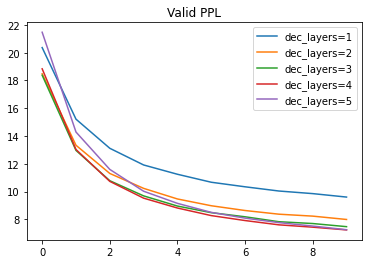

In [100]:
plt.title('Valid PPL')
plt.plot(dl_valid_ppl.iloc[:,:-1], label=dl_valid_ppl.columns[:-1])
plt.legend()
plt.show()

直观地看，3,4,5这三个值的效果不分伯仲。

放大观察，看来4或者5会是不错的选择。

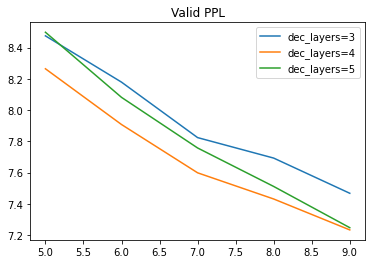

In [105]:
plt.title('Valid PPL')
plt.plot(dl_valid_ppl.iloc[5:,2:-1], label=dl_valid_ppl.columns[2:-1])
plt.legend()
plt.show()

然而，4和5的曲线在最后相交了。从曲线走势来看，4的曲线在开始变缓，而5的曲线在保持良好的下降趋势。

因此，我想如果继续训练，5的效果会比4更好。为了验证我的猜想，我对这两个模型再次进行了5个epoch的训练。

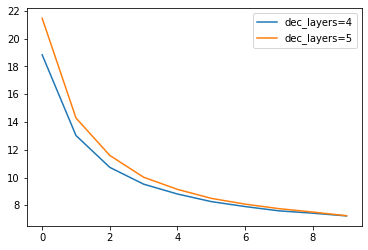

In [73]:
plt.plot(dl_valid_ppl.iloc[:,:-1], label=dl_valid_ppl.columns[:-1])
plt.legend()
plt.show()

In [152]:
# 加载和继续训练
model_path = '../models/chatbot_lr=0.0004_DecLayer=5.pth'
model_ = torch.load(model_path)

optimiser_ = torch.optim.Adam(model_.parameters(), lr=0.0004)
loss_fn = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

N_EPOCHS = 35
CLIP = 1

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model_, train_dataloader, optimiser_, loss_fn, CLIP)
    valid_loss = evaluate(model_, valid_dataloader, loss_fn)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    model_.train_ppl.append(math.exp(train_loss))
    model_.valid_ppl.append(math.exp(valid_loss))

    if valid_loss < model_.best_loss:
        model_.best_loss = valid_loss
        torch.save(model_, model_path)

    print(f'Epoch: {model_.trained_epochs:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\tVal. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

# dl_45_valid_ppl[f'dec_layers=5'] = model_.valid_ppl

train: epoch 16, iter 500
train: epoch 16, iter 1000
train: epoch 16, iter 1500
train: epoch 16, iter 2000
train: epoch 16, iter 2500
train: epoch 16, iter 3000
Epoch: 16 | Time: 10m 2s
	Train Loss: 1.744 | Train PPL:   5.722
	Val. Loss: 1.893 |  Val. PPL:   6.641
train: epoch 17, iter 500
train: epoch 17, iter 1000
train: epoch 17, iter 1500
train: epoch 17, iter 2000
train: epoch 17, iter 2500
train: epoch 17, iter 3000
Epoch: 17 | Time: 9m 45s
	Train Loss: 1.716 | Train PPL:   5.562
	Val. Loss: 1.892 |  Val. PPL:   6.630
train: epoch 18, iter 500
train: epoch 18, iter 1000
train: epoch 18, iter 1500
train: epoch 18, iter 2000
train: epoch 18, iter 2500
train: epoch 18, iter 3000
Epoch: 18 | Time: 9m 45s
	Train Loss: 1.692 | Train PPL:   5.431
	Val. Loss: 1.880 |  Val. PPL:   6.552
train: epoch 19, iter 500
train: epoch 19, iter 1000
train: epoch 19, iter 1500
train: epoch 19, iter 2000
train: epoch 19, iter 2500
train: epoch 19, iter 3000
Epoch: 19 | Time: 9m 46s
	Train Loss: 1.669 

train: epoch 47, iter 500
train: epoch 47, iter 1000
train: epoch 47, iter 1500
train: epoch 47, iter 2000
train: epoch 47, iter 2500
train: epoch 47, iter 3000
Epoch: 47 | Time: 9m 45s
	Train Loss: 1.336 | Train PPL:   3.804
	Val. Loss: 1.886 |  Val. PPL:   6.593
train: epoch 48, iter 500
train: epoch 48, iter 1000
train: epoch 48, iter 1500
train: epoch 48, iter 2000
train: epoch 48, iter 2500
train: epoch 48, iter 3000
Epoch: 48 | Time: 9m 45s
	Train Loss: 1.329 | Train PPL:   3.776
	Val. Loss: 1.894 |  Val. PPL:   6.645
train: epoch 49, iter 500
train: epoch 49, iter 1000
train: epoch 49, iter 1500
train: epoch 49, iter 2000
train: epoch 49, iter 2500
train: epoch 49, iter 3000
Epoch: 49 | Time: 9m 44s
	Train Loss: 1.322 | Train PPL:   3.752
	Val. Loss: 1.887 |  Val. PPL:   6.598
train: epoch 50, iter 500
train: epoch 50, iter 1000
train: epoch 50, iter 1500
train: epoch 50, iter 2000
train: epoch 50, iter 2500
train: epoch 50, iter 3000
Epoch: 50 | Time: 9m 45s
	Train Loss: 1.315 

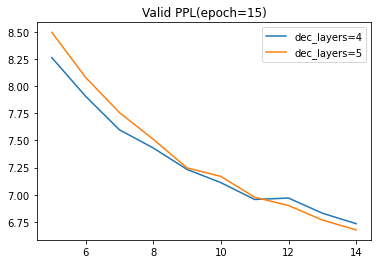

In [126]:
plt.title('Valid PPL(epoch=15)')
plt.plot(dl_45_valid_ppl[5:], label=dl_45_valid_ppl.columns)
plt.legend()
plt.show()

虽然有一定振动，但总的来看，5表现出了略胜一筹的性能。

因此，这个参数最终设定为5。

接下来，就按照这组参数进行模型训练。

- learning_rate=0.0004
- dec_layers=5

进行了50个epoch的训练之后，观察效果：

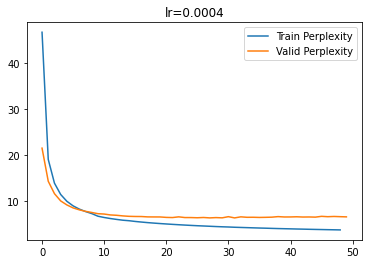

In [153]:
plt.title('lr=0.0004')
plt.plot(model_.train_ppl, label='Train Perplexity')
plt.plot(model_.valid_ppl, label='Valid Perplexity')
plt.legend()
plt.show()

从图上看，在10个epoch之后，虽然训练误差还再继续下降，但验证误差已经稳定。

In [154]:
generate_answer(next(iter(valid_dataloader))[0],tokenizer,model_,device)

['= =',
 '我 是 大 人 ， 我 知 道 你 是 大 人',
 '那 必 须 的',
 '我 是 能 做 饭 会 打 扫 还 爱 卖 萌 的 赛 巴 斯 酱 ， 亲 爱 的 阿 姿 公 主 ！',
 '是 啊 是 啊 ！ 我 是 漂 亮 勇 敢 卖 萌 的 小 通',
 '我 傻 我 快 乐 ， 我 笨 我 得 意 ！',
 '= =',
 '= =',
 '大 肥 肠',
 '= =',
 '哪 有 ， 跟 我 说 话 你 会 开 心 的 啊',
 '我 是 女 的 。 。 。',
 '孟 爷 爷 爷',
 '你 妹 的',
 'ai he vx',
 '= =',
 '= =',
 '* * * * * *',
 '我 是 小 二 货',
 '啊 啊 啊 啊 啊 啊 啊 啊 啊 啊 啊 啊 啊 〜 爽 死 了',
 '= =',
 '我 是 人 妖',
 '= =',
 '= =',
 '= =',
 '我 会 一 直 陪 着 你 的',
 '是 的 ， 我 是 鸡',
 '= =',
 '你 是 人 吗 ？ 请 回 答 。',
 '我 吃 米 。 或 者 小 虫 子 。',
 '我 们 都 有 一 个 家 ~ 名 字 叫 中 国 ~ ~ 兄 弟 姐 妹 都 很 多 ~ 景 色 也 不 错',
 '你 才 好',
 '= =',
 '你 才 是',
 '主 人 ， 么 么 哒',
 '= =',
 '我 是 小 通',
 '我 在 想 你 啊',
 '你 是 草 泥 马',
 '我 小 通 ， 72 变 ， 上 天 入 地 无 所 不 能 。 怎 么 了 ？',
 '我 是 小 通',
 '= =',
 '我 不 是 真 鸡',
 '我 再 不 理 你 了 π _ π',
 'yes, i can',
 '你 找 她 做 老 婆 就 可 以 不 许 她 宰 了',
 '你 不 是 我 你 怎 么 知 道 我 不 知 道 鸡 的 快 乐',
 '你 妹',
 '你 是 只 猪',
 '你 才 变 态 ， 你 全 家 都 是 变 态 ！',
 '是 你 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 最 的',
 '不 敢 ， 哪 儿 敢 啊 我 ！',
 '我 肩 膀 给 你 靠',
 '别 难 过 ，

In [131]:
def shell_chat(tokenizer, model, device):
    while True:
        try:
            read = input('> 你:\t')
        except EOFError:
            break
        if read == '!q':
            break
        out = generate_answer(read,tokenizer,model, device)[0]
        print(f'> Bot:\t{out}')

In [ ]:
shell_chat(tokenizer, model_, device)

> 你:	傻逼
> Bot:	你 才 是
> 你:	你现在聪明了？
> Bot:	我 也 是 这 么 想 的 ， 那 你 爱 我 么 ？
> 你:	我爱你妈
> Bot:	我 也 爱 你 主 人 〜 ( ^ ○ ^ )
> 你:	我真的哭死
> Bot:	呜 呜 呜 呜 呜 呜 哇
> 你:	你哭你妈
> Bot:	呜 呜 呜 呜 呜 呜 哇
> 你:	你哭你妈呢
> Bot:	= =
> 你:	= =
> Bot:	我 是 小 通
> 你:	你是你吗
> Bot:	我 是 小 通
> 你:	你是一坨屎
> Bot:	我 是 小 通
> 你:	ok
> Bot:	oh no! i see!
> 你:	Chinese should speak Chinese
> Bot:	哼 哼 哈 嘿 ！ 快 使 用 双 节 棍
> 你:	欧西
> Bot:	= =
> 你:	!q
> Bot:	= =
> 你:	你是哪国人
> Bot:	中 国 的 ！ ！ ！
> 你:	罕见
> Bot:	我 爱 你
> 你:	你说得对，但是原神
> Bot:	= =
> 你:	原神是米哈游开发的
> Bot:	= =
> 你:	我原神呢
> Bot:	= =
> 你:	原神
> Bot:	我 是 诚 实 的 孩 子


## 部署到web
前端使用原生html+css+js，后端使用flask

### 后端

In [ ]:
import torch
from flask import Flask, request, render_template
from mymodel.classes import *
from mymodel.utils import generate_answer, tokenizer, device

app = Flask('ChatBot')
model_path = 'models/chatbot_lr=0.0004_DecLayer=5.pth'

try:
    model = torch.load(model_path)
except:
    exit()


@app.route('/question', methods=['POST'])
def chatbot():
    text = request.data.decode(encoding='utf8')
    res = generate_answer(text, tokenizer, model, device)
    headers = {'Access-Control-Allow-Origin': 'http://127.0.0.1:5500'}
    return ({'data': res}, headers)


@app.route('/', methods=['GET', 'POST'])
def front_end():
    return render_template('index.html')


if __name__ == '__main__':
    app.run()


### 前端展示
![chat.png](attachment:chat.png)

### APP地址
http://47.108.153.18:5000/

## Thanks

### APP地址
http://47.108.153.18:5000/

## Thanks